In [1]:
from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
from forgebox.ftorch import FG

In [3]:
fg = FG("wgan")
p = fg.p

==========hyper params==========
{'hs': 1024}


### Data Pipeline

In [4]:
train = MNIST("/data/MNIST_TORCH/", train = True, transform=transforms.Compose([transforms.ToTensor()]), download=False)
valid = MNIST("/data/MNIST_TORCH/", train = False, transform=transforms.Compose([transforms.ToTensor()]), download=False)

In [5]:
from torch import nn
import torch
from torch.utils.data import DataLoader

In [6]:
# next(iter(DataLoader(train)))

In [7]:
CUDA = torch.cuda.is_available()

In [8]:
p("hs",2048)

2048

In [9]:
class G(nn.Module):
    def __init__(self, in_, hs = p("hs")):
        super().__init__()
        self.in_ = in_
        self.fcb = nn.Sequential(*[
            nn.Linear(in_,hs, ),
            nn.LeakyReLU(),
            nn.Linear(hs,hs, ),
            nn.LeakyReLU(),
            nn.Linear(hs,784),
        ])
        
    def forward(self,x, ):
        x = self.fcb(x)
        return torch.sigmoid(x)
    
    def new_images(self, number):
        x = torch.rand(number,self.in_)
        if CUDA: x=x.cuda()
        x = torch.sigmoid(self.forward(x))
        return torch.reshape(x,(number,28,28))
    
class D(nn.Module):
    def __init__(self,  hs = p("hs")):
        super().__init__()
        self.hs = hs
        self.fcb = nn.Sequential(*[
            nn.Linear(784,hs),
            nn.LeakyReLU(),
            nn.Linear(hs,hs, ),
            nn.LeakyReLU(),
            nn.Linear(hs,1),
        ])
        
    def forward(self,x):
        return self.fcb(x)

In [10]:
from forgebox.ftorch.train import Trainer
from forgebox.ftorch.callbacks import stat

from torch.optim import Adam, RMSprop

In [11]:
trainer = Trainer(dataset=train, batch_size=32, print_on=5,fg=fg, callbacks=[stat])

In [12]:
g,d = G(100,),D()
if CUDA:
    g,d = g.cuda(),d.cuda()
opt_G = RMSprop(g.parameters(),lr= 5e-5)
opt_D = RMSprop(d.parameters(),lr= 5e-5)

trainer.train_G = True
@trainer.step_train
def action(*args, **kwargs):
    if kwargs["ite"] %6 ==5:
        trainer.train_G = True
    else:
        trainer.train_G = False
    opt_G.zero_grad()
    opt_D.zero_grad()
    
    real,y = args[0]
    
    bs = real.size()[0]
    real = torch.reshape(real, (bs,784))
    z = torch.rand(bs, 100)
    
    if CUDA:
        real = real.cuda()
        z = z.cuda()
    fake = g(z)
    x = torch.cat([real,fake], dim=0)
    if trainer.train_G:
        
        loss = - d(fake).mean()
        loss.backward()
        opt_G.step()
    else:
        loss = -(d(real).mean() - d(fake).mean())
        loss.backward()
        opt_D.step()
        for p in d.parameters():
            p.data.clamp_(-1e-3, 1e-3)
    return {"loss":loss.item()}

In [13]:
trainer.train(50)

,epoch,iter,loss,timestamp
mean,0.0,937.0,-0.021928,0.009307
min,0.0,0.0,-0.100985,0.000000
max,0.0,1874.0,0.078598,17.450970


,epoch,iter,loss,timestamp
mean,1.0,937.0,-0.029189,0.009278
min,1.0,0.0,-0.057068,0.000000
max,1.0,1874.0,0.027625,17.396413


,epoch,iter,loss,timestamp
mean,2.0,937.0,-0.025476,0.009323
min,2.0,0.0,-0.048420,0.000000
max,2.0,1874.0,0.032940,17.480817


,epoch,iter,loss,timestamp
mean,3.0,937.0,-0.029221,0.009277
min,3.0,0.0,-0.053034,0.000000
max,3.0,1874.0,0.020602,17.394854


,epoch,iter,loss,timestamp
mean,4.0,937.0,-0.026621,0.009307
min,4.0,0.0,-0.046364,0.000000
max,4.0,1874.0,0.030201,17.451135


,epoch,iter,loss,timestamp
mean,5.0,937.0,-0.023674,0.009292
min,5.0,0.0,-0.045511,0.000000
max,5.0,1874.0,0.017897,17.422160


,epoch,iter,loss,timestamp
mean,6.0,937.0,-0.023247,0.009306
min,6.0,0.0,-0.039544,0.000000
max,6.0,1874.0,0.021891,17.449154


,epoch,iter,loss,timestamp
mean,7.0,937.0,-0.020087,0.009313
min,7.0,0.0,-0.032749,0.000000
max,7.0,1874.0,0.013990,17.461435


,epoch,iter,loss,timestamp
mean,8.0,937.0,-0.017893,0.009269
min,8.0,0.0,-0.027978,0.000000
max,8.0,1874.0,0.012260,17.378797


,epoch,iter,loss,timestamp
mean,9.0,937.0,-0.016704,0.009282
min,9.0,0.0,-0.026965,0.000000
max,9.0,1874.0,0.009528,17.403634


,epoch,iter,loss,timestamp
mean,10.0,937.0,-0.015666,0.009244
min,10.0,0.0,-0.025089,0.000000
max,10.0,1874.0,0.013443,17.332184


,epoch,iter,loss,timestamp
mean,11.0,937.0,-0.014838,0.009323
min,11.0,0.0,-0.022727,0.000000
max,11.0,1874.0,0.012976,17.481213


,epoch,iter,loss,timestamp
mean,12.0,937.0,-0.013875,0.009276
min,12.0,0.0,-0.021101,0.000000
max,12.0,1874.0,0.019177,17.391645


,epoch,iter,loss,timestamp
mean,13.0,937.0,-0.013126,0.009271
min,13.0,0.0,-0.022248,0.000000
max,13.0,1874.0,0.014219,17.382460


,epoch,iter,loss,timestamp
mean,14.0,937.0,-0.012652,0.009238
min,14.0,0.0,-0.020500,0.000000
max,14.0,1874.0,0.016579,17.321296


,epoch,iter,loss,timestamp
mean,15.0,937.0,-0.012093,0.009352
min,15.0,0.0,-0.022128,0.000000
max,15.0,1874.0,0.014226,17.535482


,epoch,iter,loss,timestamp
mean,16.0,937.0,-0.011578,0.009229
min,16.0,0.0,-0.020967,0.000000
max,16.0,1874.0,0.014233,17.304143


,epoch,iter,loss,timestamp
mean,17.0,937.0,-0.011065,0.009287
min,17.0,0.0,-0.019547,0.000000
max,17.0,1874.0,0.009708,17.413878


,epoch,iter,loss,timestamp
mean,18.0,937.0,-0.010649,0.009267
min,18.0,0.0,-0.020653,0.000000
max,18.0,1874.0,0.009742,17.375157


,epoch,iter,loss,timestamp
mean,19.0,937.0,-0.010258,0.009266
min,19.0,0.0,-0.024239,0.000000
max,19.0,1874.0,0.008361,17.373215


,epoch,iter,loss,timestamp
mean,20.0,937.0,-0.009936,0.009407
min,20.0,0.0,-0.022374,0.000000
max,20.0,1874.0,0.012357,17.637203


,epoch,iter,loss,timestamp
mean,21.0,937.0,-0.009597,0.009301
min,21.0,0.0,-0.021095,0.000000
max,21.0,1874.0,0.013557,17.440104


,epoch,iter,loss,timestamp
mean,22.0,937.0,-0.009300,0.009294
min,22.0,0.0,-0.022802,0.000000
max,22.0,1874.0,0.011502,17.426731


,epoch,iter,loss,timestamp
mean,23.0,937.0,-0.008981,0.009261
min,23.0,0.0,-0.020118,0.000000
max,23.0,1874.0,0.014599,17.364126


,epoch,iter,loss,timestamp
mean,24.0,937.0,-0.008698,0.009293
min,24.0,0.0,-0.024631,0.000000
max,24.0,1874.0,0.008567,17.423605


,epoch,iter,loss,timestamp
mean,25.0,937.0,-0.008492,0.009302
min,25.0,0.0,-0.026806,0.000000
max,25.0,1874.0,0.013845,17.442051


,epoch,iter,loss,timestamp
mean,26.0,937.0,-0.008272,0.009330
min,26.0,0.0,-0.022317,0.000000
max,26.0,1874.0,0.010214,17.493988


,epoch,iter,loss,timestamp
mean,27.0,937.0,-0.008066,0.009294
min,27.0,0.0,-0.022605,0.000000
max,27.0,1874.0,0.012105,17.425871


,epoch,iter,loss,timestamp
mean,28.0,937.0,-0.007941,0.009312
min,28.0,0.0,-0.022782,0.000000
max,28.0,1874.0,0.010663,17.459372


,epoch,iter,loss,timestamp
mean,29.0,937.0,-0.007779,0.009328
min,29.0,0.0,-0.024502,0.000000
max,29.0,1874.0,0.008874,17.490205


,epoch,iter,loss,timestamp
mean,30.0,937.0,-0.007614,0.009269
min,30.0,0.0,-0.023572,0.000000
max,30.0,1874.0,0.010145,17.380186


,epoch,iter,loss,timestamp
mean,31.0,937.0,-0.007482,0.009323
min,31.0,0.0,-0.024490,0.000000
max,31.0,1874.0,0.011411,17.481005


,epoch,iter,loss,timestamp
mean,32.0,937.0,-0.007489,0.009306
min,32.0,0.0,-0.025993,0.000000
max,32.0,1874.0,0.015720,17.449307


,epoch,iter,loss,timestamp
mean,33.0,937.0,-0.007677,0.009287
min,33.0,0.0,-0.021722,0.000000
max,33.0,1874.0,0.003989,17.413509


,epoch,iter,loss,timestamp
mean,34.0,937.0,-0.007481,0.009287
min,34.0,0.0,-0.018881,0.000000
max,34.0,1874.0,0.005520,17.413713


,epoch,iter,loss,timestamp
mean,35.0,937.0,-0.007306,0.009369
min,35.0,0.0,-0.024231,0.000000
max,35.0,1874.0,0.009833,17.566612


,epoch,iter,loss,timestamp
mean,36.0,937.0,-0.007054,0.009272
min,36.0,0.0,-0.023017,0.000000
max,36.0,1874.0,0.011506,17.384189


,epoch,iter,loss,timestamp
mean,37.0,937.0,-0.006918,0.009283
min,37.0,0.0,-0.025450,0.000000
max,37.0,1874.0,0.009682,17.404689


,epoch,iter,loss,timestamp
mean,38.0,937.0,-0.006827,0.009289
min,38.0,0.0,-0.022984,0.000000
max,38.0,1874.0,0.010328,17.416127


,epoch,iter,loss,timestamp
mean,39.0,937.0,-0.006716,0.009303
min,39.0,0.0,-0.025308,0.000000
max,39.0,1874.0,0.008983,17.443747


,epoch,iter,loss,timestamp
mean,40.0,937.0,-0.006628,0.009327
min,40.0,0.0,-0.022742,0.000000
max,40.0,1874.0,0.016714,17.488835


,epoch,iter,loss,timestamp
mean,41.0,937.0,-0.006532,0.009280
min,41.0,0.0,-0.023749,0.000000
max,41.0,1874.0,0.009106,17.399669


,epoch,iter,loss,timestamp
mean,42.0,937.0,-0.006455,0.009321
min,42.0,0.0,-0.027725,0.000000
max,42.0,1874.0,0.008189,17.476671


,epoch,iter,loss,timestamp
mean,43.0,937.0,-0.006342,0.009275
min,43.0,0.0,-0.024724,0.000000
max,43.0,1874.0,0.014390,17.391456


,epoch,iter,loss,timestamp
mean,44.0,937.0,-0.006291,0.009286
min,44.0,0.0,-0.030663,0.000000
max,44.0,1874.0,0.009438,17.411225


,epoch,iter,loss,timestamp
mean,45.0,937.0,-0.006165,0.009283
min,45.0,0.0,-0.023636,0.000000
max,45.0,1874.0,0.011977,17.406478


,epoch,iter,loss,timestamp
mean,46.0,937.0,-0.006126,0.009286
min,46.0,0.0,-0.023421,0.000000
max,46.0,1874.0,0.008664,17.411675


,epoch,iter,loss,timestamp
mean,47.0,937.0,-0.006106,0.009332
min,47.0,0.0,-0.020930,0.000000
max,47.0,1874.0,0.012252,17.497680


,epoch,iter,loss,timestamp
mean,48.0,937.0,-0.006343,0.009302
min,48.0,0.0,-0.020321,0.000000
max,48.0,1874.0,0.004132,17.440373


,epoch,iter,loss,timestamp
mean,49.0,937.0,-0.006110,0.009295
min,49.0,0.0,-0.022344,0.000000
max,49.0,1874.0,0.005958,17.427710


In [14]:
from matplotlib import pyplot as plt
%matplotlib inline

In [15]:
images = g.new_images(10)
if CUDA: images = images.cpu()

In [16]:
from IPython.display import display_jpeg

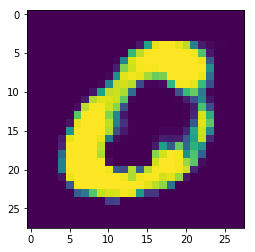

In [17]:
plt.imshow(images.data.numpy()[0])

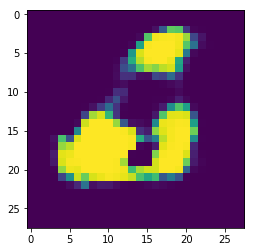

In [18]:
plt.imshow(images.data.numpy()[1])

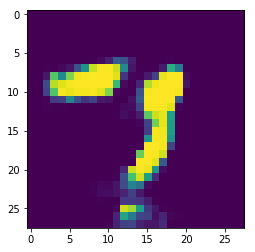

In [19]:
plt.imshow(images.data.numpy()[2])

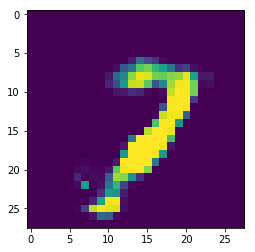

In [20]:
plt.imshow(images.data.numpy()[3])

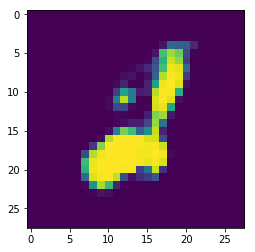

In [21]:
plt.imshow(images.data.numpy()[4])